## 0-Packages

In [378]:
import websockets
import pandas as pd 
import numpy as np 
import json 
import ta 
import yfinance as yf 
import matplotlib.pyplot as plt 

In [379]:
stream = \
websockets.connect('wss://stream.binance.com:9443/stream?streams=adausdt@miniTicker')


In [380]:
def createframe(msg):
    df = pd.DataFrame([msg])
    df = df.loc[:,['s','E','c']]
    df.columns = ['symbol','Time','Price']
    df.Price = df.Price.astype(float)
    df.Time = pd.to_datetime(df.Time,unit='ms')
    return df 

https://levelup.gitconnected.com/method-types-in-python-2c95d46281cd

In [5]:
## cls vs self : self modifie tous les objets , cls un objet unique 

In [6]:
# static method pas besoin d'instancier l'objet pour l'utiliser 

In [4]:
class order:
    buy = {}
    sell = {}
    
    def __init__(self,price,quantity,time=pd.to_datetime('now')):
        self.buy['time']= time
        self.buy['price']= price
        self.buy['quantity']= quantity 
    
    
    def addsell(self,price,quantity,time = pd.to_datetime('now')):
        self.sell['time']= time
        self.sell['price']= price
        self.sell['quantity']= quantity
        
    
    def getbuy(self):
        try : 
            price =  self.buy['price']
            time = self.buy['time']
            quantity = self.buy['quantity']
            return price,time,quantity
            
        except : 
            print('empty buy for this order !')
                
    def getsell(cls):
        try : 
            price =  self.sell['price']
            time = self.sell['time']
            quantity = self.sell['quantity']
            return price,time,quantity
            
        except : 
            print('empty sell for this order !')   

In [42]:
import copy

In [43]:
orderlist=[]
for i in range(10):
    pos = copy.copy(order(price=200, quantity =i ))
    
    orderlist.append(pos)

In [45]:
[i.getbuy() for i in orderlist]

[(200, Timestamp('2022-11-12 11:48:20.913400'), 9),
 (200, Timestamp('2022-11-12 11:48:20.913400'), 9),
 (200, Timestamp('2022-11-12 11:48:20.913400'), 9),
 (200, Timestamp('2022-11-12 11:48:20.913400'), 9),
 (200, Timestamp('2022-11-12 11:48:20.913400'), 9),
 (200, Timestamp('2022-11-12 11:48:20.913400'), 9),
 (200, Timestamp('2022-11-12 11:48:20.913400'), 9),
 (200, Timestamp('2022-11-12 11:48:20.913400'), 9),
 (200, Timestamp('2022-11-12 11:48:20.913400'), 9),
 (200, Timestamp('2022-11-12 11:48:20.913400'), 9)]

## 1-Intraday : rate of change (30 secondes condition)
- buy condition : rate of change positif sur les 30 dernières secondes 
- sell condition : TSL 0.5% à ou gain de 0.2 %

In [288]:
df = pd.DataFrame()
orderlist = []
open_position = False

async with stream as receiver : 
    while True : 
        data = await receiver.recv()
        data = json.loads(data)['data']
        df = pd.concat([df,createframe(data)]).reset_index(drop=True)
        print(df.tail(1))
        
        if not open_position and ta.momentum.roc(df.Price,30).iloc[-1] >0:
            buyprice = df.iloc[-1].Price
            pos = order(price = buyprice, quantity = 50)
            print(f'BUY ORDER : {pos.getbuy()}')
            open_position = True
            
            
        if open_position : 
            subdf = df[df.Time >= pd.to_datetime(pos.getbuy()[1],unit='ms')]
            # ça s'actualise en base revoir la logique
            if len(subdf)>1:
                subdf['highest'] = subdf.Price.cummax()
                subdf['trailingstop'] = subdf['highest']*0.995
                
                if subdf.iloc[-1].Price < subdf.iloc[-1]['trailingstop'] \
                    or subdf.iloc[-1].Price > buyprice * 1.002:
                    
                    sellprice = subdf.iloc[-1].Price
                    pos.addsell(price = sellprice ,quantity =50)
                    print(f'SELL ORDER : {pos.getsell()}')
                    open_position = False
                    print(f"You made {(sellprice - buyprice)/buyprice} profit")
                    orderlist.append(pos)
                    open_position = False
                     

    symbol                    Time   Price
0  ADAUSDT 2022-11-08 15:05:20.915  0.3907
    symbol                    Time   Price
1  ADAUSDT 2022-11-08 15:05:21.960  0.3908
    symbol                    Time   Price
2  ADAUSDT 2022-11-08 15:05:22.942  0.3908
    symbol                    Time   Price
3  ADAUSDT 2022-11-08 15:05:23.394  0.3908
    symbol                    Time   Price
4  ADAUSDT 2022-11-08 15:05:24.901  0.3907
    symbol                    Time   Price
5  ADAUSDT 2022-11-08 15:05:25.825  0.3907
    symbol                    Time   Price
6  ADAUSDT 2022-11-08 15:05:26.812  0.3907
    symbol                    Time   Price
7  ADAUSDT 2022-11-08 15:05:28.080  0.3906
    symbol                    Time   Price
8  ADAUSDT 2022-11-08 15:05:31.786  0.3906
    symbol                    Time   Price
9  ADAUSDT 2022-11-08 15:05:31.896  0.3906
     symbol                    Time   Price
10  ADAUSDT 2022-11-08 15:05:33.450  0.3905
     symbol                    Time   Price
11  ADAU

CancelledError: 

In [291]:
orderlist

In [289]:
#simuler tout ça avec un iterows():
profit  = (orderlist[0].getsell()[0] - orderlist[0].getbuy()[0])/orderlist[0].getbuy()[0]

timedelta = (orderlist[0].getsell()[1] - orderlist[0].getbuy()[1])

In [297]:
sum([(orderlist[i].getsell()[0] - orderlist[i].getbuy()[0])/orderlist[i].getbuy()[0] for i in range(len(orderlist))])

-0.08669046404894475

In [264]:
from datetime import datetime

## 2-Daytrading : regression price estimation

- buy condition  : y_estimé > y 
- sell condition : y_estimé < y 

idée (rajouter un TSL)

In [4]:
import statsmodels.api as sm 
import matplotlib.pyplot as plt 

In [5]:
df = yf.download(tickers = 'AAPL', start = '2022-01-01' ,interval = '1d')
df.head(2)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-31,178.089996,179.229996,177.259995,177.570007,176.545380,64062300
2022-01-03,177.830002,182.880005,177.710007,182.009995,180.959747,104487900


In [6]:
lsma_arr = []
dates_arr = []

window = 25

for i in range(len(df)-(window-1)):
    input_reg = df[i:i+window]
    X = pd.Series(range(window)).values
    y = input_reg.Close 
    model = sm.OLS(y,sm.add_constant(X)).fit()
    pred = model.predict()[-1]
    
    lsma_arr.append(pred)
    dates_arr.append(input_reg.iloc[-1].name)


lsma_df = pd.DataFrame({'LSMA':lsma_arr}, index = dates_arr)

all_df = pd.concat([df,lsma_df],axis=1)

all_df.dropna(inplace=True)

all_df['signal_buy'] = all_df.Close < all_df.LSMA

all_df['signal_sell'] = all_df.Close > all_df.LSMA

all_df['shifted_open'] = all_df.Close.shift(-1)

In [7]:
all_df

,Open,High,Low,Close,Adj Close,Volume,LSMA,signal_buy,signal_sell,shifted_open
2022-02-04,171.679993,174.100006,170.679993,172.389999,171.613632,82465400,166.478614,False,True,171.660004
2022-02-07,172.860001,173.949997,170.949997,171.660004,170.886917,77251200,167.144892,False,True,174.830002
2022-02-08,171.729996,175.350006,171.429993,174.830002,174.042633,74829200,168.698861,False,True,176.279999
2022-02-09,176.050003,176.649994,174.899994,176.279999,175.486099,71285000,170.352923,False,True,172.119995
2022-02-10,174.139999,175.479996,171.550003,172.119995,171.344833,90865900,171.028952,False,True,168.639999
...,...,...,...,...,...,...,...,...,...,...
2022-11-07,137.110001,139.149994,135.669998,138.919998,138.919998,83374600,146.331017,True,False,139.500000
2022-11-08,140.410004,141.429993,137.490005,139.500000,139.500000,89908500,145.684956,True,False,134.869995
2022-11-09,138.500000,138.550003,134.589996,134.869995,134.869995,74917800,144.425755,True,False,146.869995
2022-11-10,141.240005,146.869995,139.500000,146.869995,146.869995,118854000,145.004615,False,True,149.699997


In [8]:
# Set object 
# Reference to an instance python non pas à la classe
# Javascript "new"

In [190]:
in_position = False

orderlist = []

for idx, val in all_df.iterrows():
    if not in_position :
        if val.signal_buy:
            orderlist.append(copy(order(price = val.shifted_open, quantity = 1 , time = idx))
            in_position = True 
            
    if in_position :
        if val.signal_sell:
            orderlist[-1].addsell(price = val.shifted_open, quantity = 1, time = idx)
            in_position = False 
 


buy_df = pd.concat([pd.Series(po.getbuy())  for po in orderlist],axis=1).transpose()

buy_df.columns = ['buy_p','buy_t','buy_q']
    
sell_df = pd.concat([pd.Series(po.getsell())  for po in orderlist],axis=1).transpose()

sell_df.columns = ['sell_p','sell_t','sell_q']  
                             
pd.concat([buy_df,sell_df],axis=1)

SyntaxError: invalid syntax (3312234288.py, line 9)

In [9]:
buyprices,buydates=[],[]

sellprices,selldates=[],[]

in_position = False 


for idx, val in all_df.iterrows():
    if not in_position :
        if val.signal_buy:
            buyprices.append(val.shifted_open)
            buydates.append(idx)
            
            in_position = True 
            
    if in_position :
        if val.signal_sell:
            sellprices.append(val.shifted_open)
            selldates.append(idx)
            in_position = False 
 


In [29]:
table = pd.DataFrame({"buyprices":buyprices,
              "buydates":buydates,
              "sellprices":sellprices,
              "selldates":selldates
               })

In [46]:
table.head()

,buyprices,buydates,sellprices,selldates,profits
0,168.880005,2022-02-11,172.550003,2022-02-15,-0.021269
1,167.300003,2022-02-17,166.229996,2022-03-02,0.006437
2,157.440002,2022-03-07,158.520004,2022-03-09,-0.006813
3,154.729996,2022-03-10,160.619995,2022-03-16,-0.036670
4,171.830002,2022-04-05,157.649994,2022-04-28,0.089946


In [34]:
table['profits']= profits

In [32]:
profits = pd.Series([ (sell/buy)-1 for sell,buy in zip(buyprices,sellprices) ])

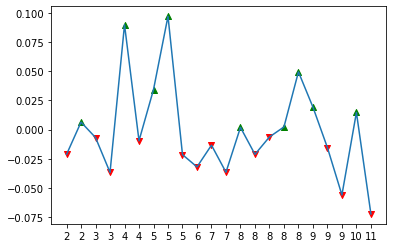

In [45]:
profits.plot()

plt.scatter(table.loc[table.profits >0,:].index , table.loc[table.profits >0,:].profits,color='green',marker='^')

plt.scatter(table.loc[table.profits <0,:].index, table.loc[table.profits <0,:].profits,color='red',marker='v')

plt.xticks(range(len(table)),[i.month for i in table.buydates])

plt.show()

## 3-Bandes de Bollinger Cross 

- The trend : above the 200d MA
- The pull back : Stock closes 2.5 std deviation below the 20d BB 
- Entry : place a 3% buy limit order below the previous day closing price 
- Exit : 2-day RSI >50  or after 10 trading days 

### Rappel RSI
-  RS -> Average Upmove / Average Downmove
-  RSI -> 100 - 100/(1+RS)

**RSI plus grand que 50 revient à dire qu'il ya plus de up que de down**


+ RSI est haut -> RS est haut -> avg(upmove) > avg(downmove)

+ RSI est bas -> RS est bas -> avg(upmove) <= avg(downmove)


**RSI équilibre = 50  -> avg(upmove) = avg(downmove)**

In [32]:
df = yf.download(tickers = 'AAPL', start = '2015-01-01',end='2021-12-31')
df.head(2)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-31,28.2050,28.282499,27.5525,27.594999,24.839493,165613600
2015-01-02,27.8475,27.860001,26.8375,27.332500,24.603207,212818400


In [33]:
len(df)

1763

In [34]:
def applyindicators(df):
    df['SMA_200'] = df.Close.rolling(window=200).mean()
    df['SMA_20'] = df.Close.rolling(window=20).mean()
    
    df['stddev'] = df.Close.rolling(window=20).std()
    df['Upper'] = df.SMA_20 + 2.5 * df.stddev
    df['Lower'] = df.SMA_20 - 2.5 * df.stddev
    df['rsi']= ta.momentum.rsi(df.Close,2)

In [35]:
applyindicators(df)

In [36]:
df.iloc[201]

Open         2.770000e+01
High         2.793750e+01
Low          2.752750e+01
Close        2.793250e+01
Adj Close    2.546270e+01
Volume       1.190368e+08
SMA_200      3.033534e+01
SMA_20       2.789888e+01
stddev       4.244257e-01
Upper        2.895994e+01
Lower        2.683781e+01
rsi          6.452444e+01
Name: 2015-10-19 00:00:00, dtype: float64

In [37]:
np.where((df.Close > df.SMA_200) & 
                          (df.Close < df.Lower) &  
                          (0.97 * df.Close >= df.Low.shift(-1)),1,0)

array([0, 0, 0, ..., 0, 0, 0])

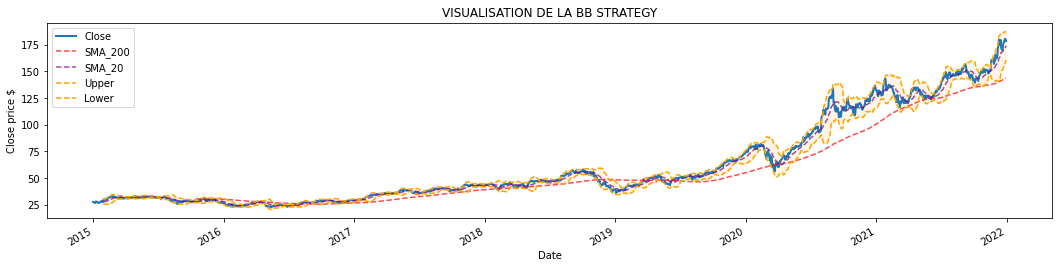

In [38]:
## VISUALISER La 

plt.figure(figsize=(18,4))

plt.title('VISUALISATION DE LA BB STRATEGY')

df['Close'].plot(label='Close',lw=2)

df['SMA_200'].plot(color ='red',alpha=0.7,ls='--')

df['SMA_20'].plot(color ='purple',alpha=0.7,ls='--')

df['Upper'].plot(color ='orange',ls='--')
df['Lower'].plot(color ='orange',ls='--')


plt.fill_between(df['Upper'].index,df['Lower'],df['Upper'],color='orange',alpha=0.1)
plt.ylabel('Close price $')

plt.legend()

In [103]:
def conditions(df):
    df['Buy'] = np.where((df.Close > df.SMA_200) & 
                          (df.Close < df.Lower) &  
                          (0.97 * df.Close >= df.Low.shift(-1)),1,0)
    
    df['Sell'] = np.where((df.rsi > 50),1,0)
    
    df['Buyprice'] = 0.97 * df.Open.shift(-2)
    
    df['Sellprice'] = df.Open.shift(-1)
    

In [104]:
conditions(df)

In [110]:
buyprices,buydates=[],[]

sellprices,selldates=[],[]

in_position = False 


for idx, val in df.iterrows():
    if not in_position :
        if val.Buy == 1:
            buyprices.append(val.Buyprice)
            buydates.append(idx)
            
            in_position = True 
            
    if in_position :
        if val.Sell == 1 :
            sellprices.append(val.Sellprice)
            selldates.append(idx)
            in_position = False 
 

In [111]:
profits = pd.Series([(sell/buy)-1 for sell,buy in zip(buyprices,sellprices) ])

In [112]:
profits.describe()

count    2.000000
mean    -0.056417
std      0.040068
min     -0.084750
25%     -0.070583
50%     -0.056417
75%     -0.042251
max     -0.028085
dtype: float64

In [115]:
(1+profits).cumprod()-1

0   -0.028085
1   -0.110454
dtype: float64

In [49]:
import scipy.stats as sc 

In [52]:
sc.norm.cdf(2.5, loc=0, scale=1) - sc.norm.cdf(-2.5, loc=0, scale=1)

0.9875806693484477

In [56]:
sc.norm.interval(0.99, loc=0, scale=1)

(-2.5758293035489004, 2.5758293035489004)

## 4- Minutes rate of change 5min / 10min 

In [381]:
tick = 'ETH-EUR'


df = yf.download(tickers = tick, period = '1y',interval = '1d')
df.head(2)

df['10m_return']= ta.momentum.roc(df.Close,10)

df['5m_return']= ta.momentum.roc(df.Close,5)

df.dropna(inplace=True)

df['signal'] = (df['10m_return']>0) & (df['5m_return']< -0.015)

df['shifted_open'] = df.Open.shift(-1)

buyprices,buydates=[],[]

sellprices,selldates=[],[]

in_position = False 


for idx, val in df.iterrows():
    if not in_position :
        if val.signal:
            
            buyprice = val.shifted_open
            sl_anchor = buyprice
            
            buyprices.append(buyprice)
            buydates.append(idx)
            
            in_position = True 
            
    
    if in_position :
    # equivalent to cummax()
        if val.Close > sl_anchor :
            sl_anchor = val.Close
            
        if (val.Close < sl_anchor * 0.99) or (val.Close > buyprice * 1.015):    
            
            sellprices.append(val.shifted_open)
            selldates.append(idx)
            in_position = False 


trades = pd.DataFrame(data =[buydates,buyprices,sellprices,selldates]).transpose()

trades.columns = ['buydates','buyprices','sellprices','selldates']

trades['ret'] = (trades.sellprices / trades.buyprices)-1

trades['cumret'] = ((1+trades.ret).cumprod()) -1

trades.dropna(inplace=True)

tradesMetrics = pd.DataFrame({
              'Global Trading period' : [trades.iloc[-1,0] - trades.iloc[0,0]],
              'Number of trades' : [len(trades)],
              'Number of win' : [(trades.ret >0).sum()],
              'Number of loss': [(trades.ret <=0).sum()],
              'Win rate [%]' : [((trades.ret >0).sum()/len(trades))*100],
              'Rate of change during period [%]' : [np.round((df.iloc[-1,0]/df.iloc[0,0] - 1),4)*100],
              'Cumulative return [%]' : [np.round(trades.cumret.iloc[-1],4)*100],
              'Mean Return [%]' : [(np.round(trades.ret.mean(),4))*100],
              'Std Return [%]' : [(np.round(trades.ret.std(),4))*100],
              'Maximum DrawDown [%]' : [(np.round(trades.ret.min(),4))*100],
              'Maximum Return [%]' : [(np.round(trades.ret.max(),4))*100]
})

tradesMetrics['tickers'] = tick

tickers = {tick:(trades,tradesMetrics)}

[*********************100%***********************]  1 of 1 completed


In [383]:
tickers[tick][1]

,Global Trading period,Number of trades,Number of win,Number of loss,Win rate [%],Rate of change during period [%],Cumulative return [%],Mean Return [%],Std Return [%],Maximum DrawDown [%],Maximum Return [%],tickers
0,343 days,23,11,12,47.826087,-69.3,22.61,1.0,4.76,-5.7,13.43,ETH-EUR


<AxesSubplot:>

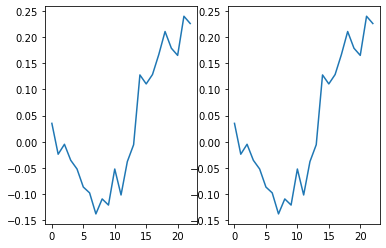

In [387]:
plt.subplot(1,2,1)
tickers[tick][0].cumret.plot()

plt.subplot(1,2,2)
tickers[tick][0].cumret.plot()

## 5-MACD Strategy 

In [493]:
import requests 
import pandas as pd 
import json

In [494]:
ep1 = 'https://api.binance.com/api/v3/exchangeInfo?symbol=BTCEUR'

ep2 = 'https://api.binance.com/api/v3/klines?symbol=BTCEUR&interval=1m&limit=10'

In [495]:
response = requests.get(ep2)

In [496]:
len(response.json())

10

In [497]:
frame = pd.DataFrame(response.json())

frame.columns = ['Kline_open_time',
                 'Open price',
                 'High price',
                 'Low price',
                 'Close price',
                 'Volume',
                 'Kline Close time',
                 'Quote asset volume',
                 'Number of trades',
                 'Taker buy base asset volume',
                 'Taker buy quote asset volume',
                 'unused']  

In [498]:
frame

,Kline_open_time,Open price,High price,Low price,Close price,Volume,Kline Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,unused
0,1668624120000,15963.12000000,15979.20000000,15961.04000000,15977.03000000,1.98108000,1668624179999,31638.95443040,41,1.44092000,23017.08407260,0
1,1668624180000,15976.21000000,15976.27000000,15963.29000000,15976.27000000,2.17271000,1668624239999,34698.28118090,22,0.04074000,650.85189810,0
2,1668624240000,15976.75000000,15984.23000000,15968.36000000,15978.93000000,0.36438000,1668624299999,5823.33139280,11,0.35568000,5684.38426200,0
3,1668624300000,15978.93000000,15984.80000000,15969.99000000,15973.87000000,0.14430000,1668624359999,2305.69820930,21,0.12486000,1995.14303400,0
4,1668624360000,15979.55000000,15981.45000000,15966.09000000,15966.09000000,0.70548000,1668624419999,11268.53757610,28,0.11231000,1794.56334030,0
5,1668624420000,15966.09000000,15975.40000000,15964.65000000,15964.65000000,0.42026000,1668624479999,6710.07988130,20,0.03089000,493.46952220,0
6,1668624480000,15961.92000000,15964.31000000,15950.02000000,15950.19000000,4.78111000,1668624539999,76277.04097400,44,0.85837000,13692.42538330,0
7,1668624540000,15959.83000000,15965.11000000,15950.27000000,15964.60000000,0.63295000,1668624599999,10102.20057500,25,0.61888000,9877.76340340,0
8,1668624600000,15961.15000000,15964.15000000,15947.51000000,15947.51000000,1.21093000,1668624659999,19319.42591150,41,0.56630000,9036.95058000,0
9,1668624660000,15955.10000000,15959.63000000,15947.51000000,15957.23000000,0.09183000,1668624719999,1465.25991590,16,0.08483000,1353.62084620,0


In [499]:
import pandas as pd

pd.to_datetime(frame['Kline_open_time'],unit='ms')

0   2022-11-16 18:42:00
1   2022-11-16 18:43:00
2   2022-11-16 18:44:00
3   2022-11-16 18:45:00
4   2022-11-16 18:46:00
5   2022-11-16 18:47:00
6   2022-11-16 18:48:00
7   2022-11-16 18:49:00
8   2022-11-16 18:50:00
9   2022-11-16 18:51:00
Name: Kline_open_time, dtype: datetime64[ns]

In [506]:
start = pd.to_datetime('2022-11-14 11:23:00').timestamp()

In [507]:
start

1668424980.0

In [508]:
int(start*1000)

1668424980000